In [11]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('../E-commerce_dataset.csv',low_memory=False)
user_summary = df.groupby('ip').agg({
    'sales': 'sum',
    'returned_amount': 'sum'
}).reset_index()
user_summary['return_ratio'] = user_summary['returned_amount'] / user_summary['sales']
user_summary['status'] = user_summary['return_ratio'].apply(
    lambda x: 'Trouble' if x > 0.5 else 'Normal'
)

### Step 1: How many users are actually in trouble?
I wanted to see the overall picture. By classifying users into “Normal” and “Trouble” based on their return ratio, I plotted a pie chart to show the proportions.

**Conclusion:**
The chart shows that a noticeable share of users ***(13.1%)*** fall into the “Trouble” category. This isn’t just a few isolated cases — it’s a broader issue. Keeping track of this ratio over time will help me see if the problem is growing.


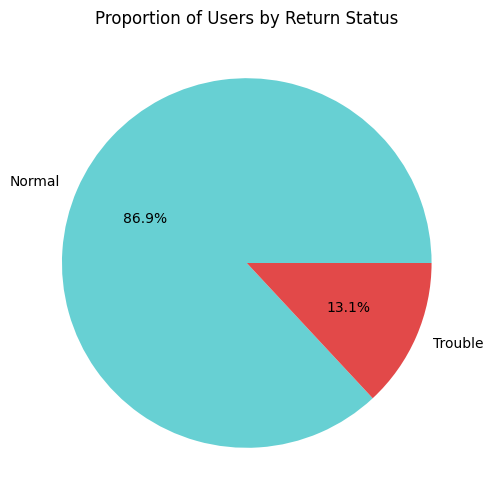

status
Normal     119272
Trouble     17927
Name: count, dtype: int64


In [33]:
status_counts = user_summary['status'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', colors=["#67d0d3", "#e24949"])
plt.title('Proportion of Users by Return Status')
plt.show()
print(user_summary['status'].value_counts())

### Step 2: Looking at the biggest returners
I continued by checking which IPs had the highest return amounts. A simple bar chart of the top 20 users makes it clear who’s returning the most.

**Conclusion:**
A handful of IPs dominate the returns. The top five are especially suspicious and deserve closer attention. These are the first ones I’d flag for review


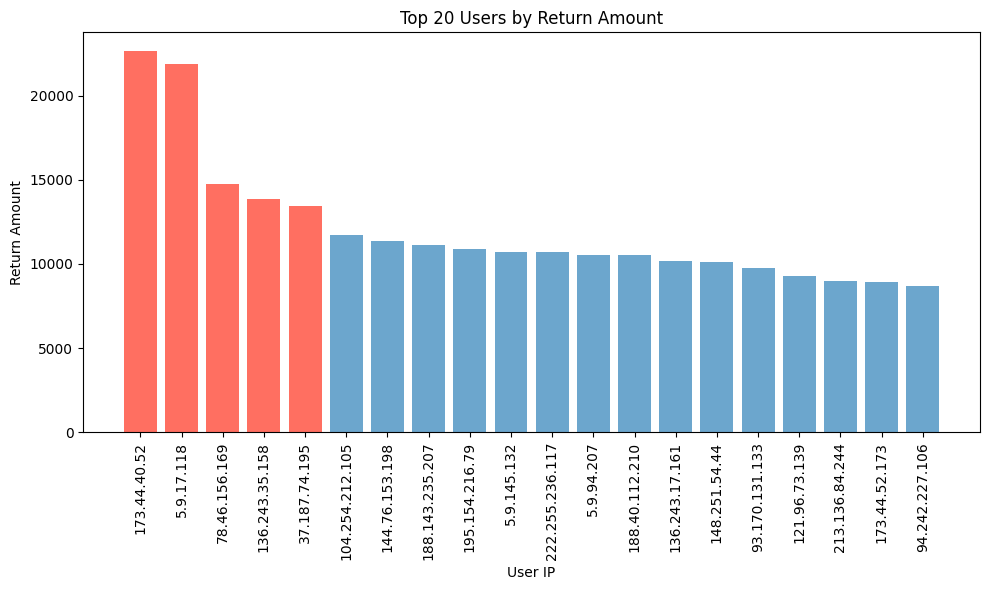

In [13]:
top20_users = user_summary.sort_values(by='returned_amount', ascending=False).head(20)
gentle_red = "#FF6F61"  
gentle_blue = "#6CA6CD" 
colors = [gentle_red if i < 5 else gentle_blue for i in range(len(top20_users))]

plt.figure(figsize=(10,6))
plt.bar(top20_users['ip'], top20_users['returned_amount'], color=colors)
plt.title('Top 20 Users by Return Amount')
plt.xlabel('User IP')
plt.ylabel('Return Amount')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Step 3: Comparing sales and returns
To understand behavior better, I plotted sales against returns for each user. Normal users are shown in blue, trouble users in red.

**Conclusion:**
The scatter plot makes the difference obvious. Normal users cluster around balanced sales and returns, while trouble users stand out with high returns and little or no sales. This confirms that their behavior is unusual and worth investigating


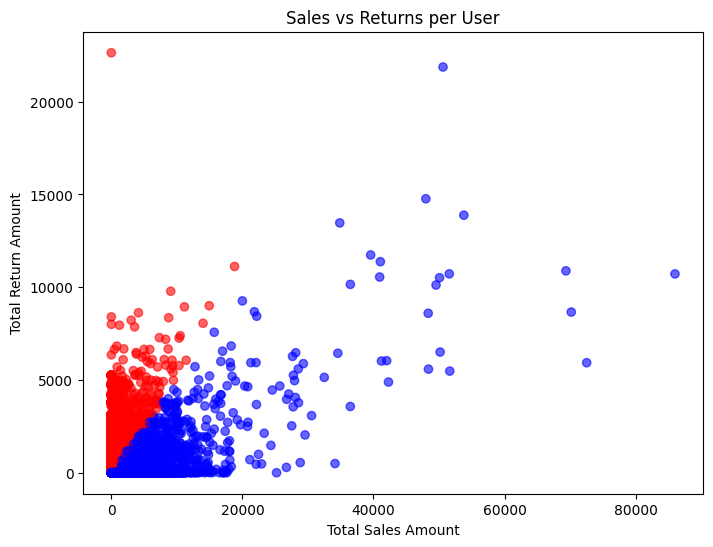

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(user_summary['sales'], user_summary['returned_amount'],
            c=user_summary['status'].map({'Normal':'blue','Trouble':'red'}),
            alpha=0.6)

plt.title('Sales vs Returns per User')
plt.xlabel('Total Sales Amount')
plt.ylabel('Total Return Amount')
plt.show()

### Step 4: Checking subnet patterns (/16)
I then grouped IPs by their first two octets (the /16 subnet) to see if trouble users are concentrated in certain ranges.

**Conclusion:**
Some subnets, like 107.77 and 1.39, have dozens of trouble IPs. That suggests broad hotspots where suspicious activity is common. These ranges should be monitored more closely.


In [15]:
user_summary['subnet'] = user_summary['ip'].str.split('.').str[:2].str.join('.')
subnet_counts = (user_summary.loc[user_summary['status'] == 'Trouble']
                 .groupby('subnet')['ip']
                 .nunique()
                 .sort_values(ascending=False))

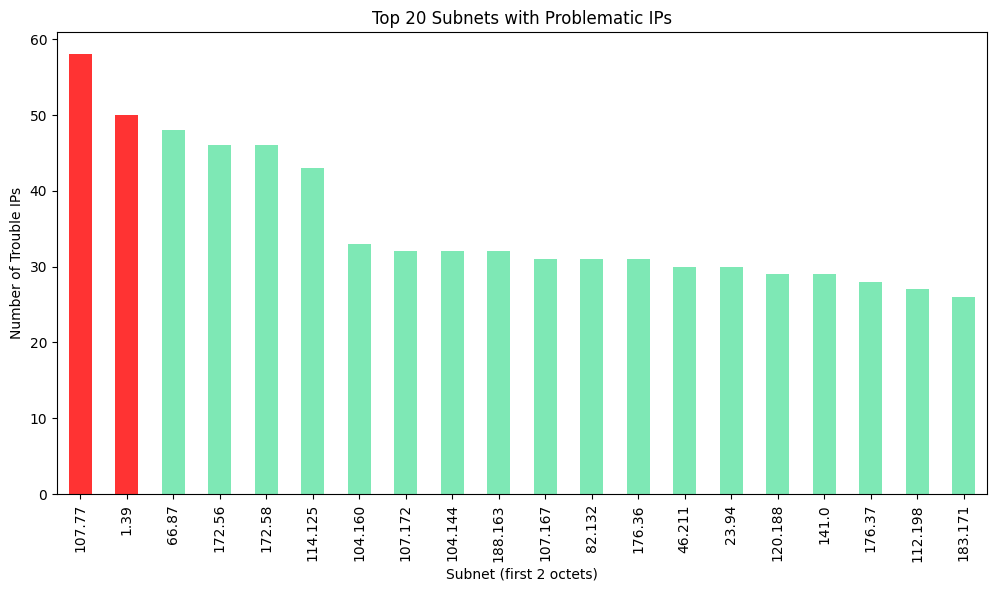

In [31]:
colors = ["#FF0000" if i < 2 else "#5EE3A3" for i in range(len(top20_users))]
subnet_counts.head(20).plot(kind='bar', figsize=(12,6), color=colors, alpha=0.8)
plt.title("Top 20 Subnets with Problematic IPs")
plt.xlabel("Subnet (first 2 octets)")
plt.ylabel("Number of Trouble IPs")
plt.show()

### Step 5: Zooming in further (/24)
Finally, I looked at the first three octets (/24 subnet) to see if there are tighter clusters.

**Conclusion:**
Subnets like 141.0.14 and 141.0.15 each contain 11 trouble IPs. That kind of clustering points to coordinated activity, possibly proxy farms or bots. These subnets need deeper investigation, including checking which providers own them.


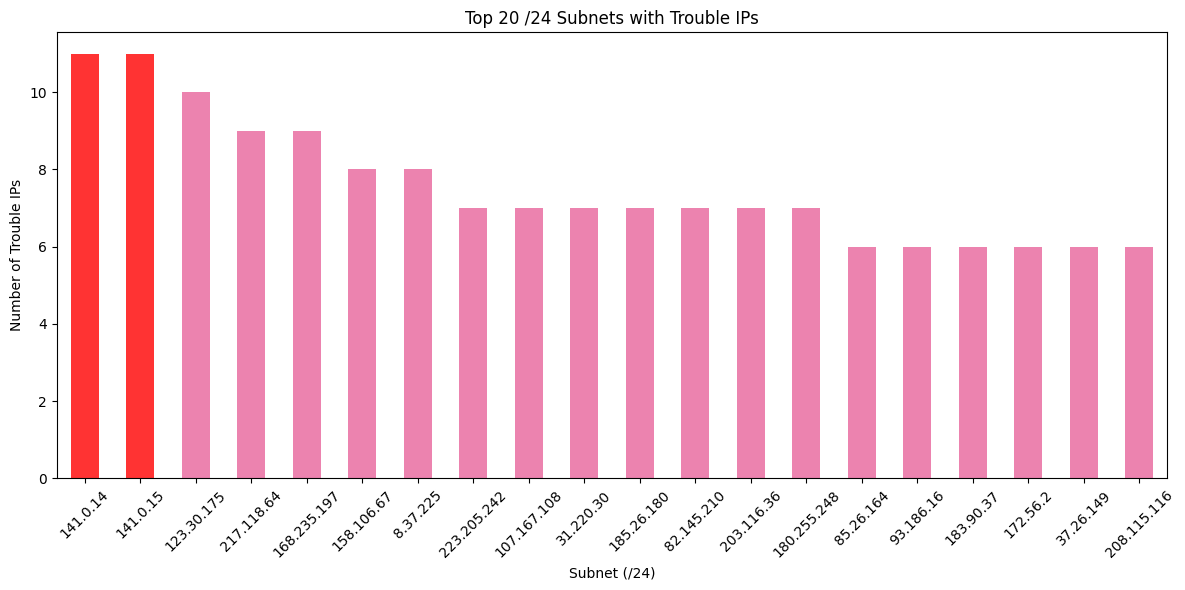

In [23]:
user_summary['subnet_24'] = user_summary['ip'].str.split('.').str[:3].str.join('.')
subnet_24_counts = (user_summary.loc[user_summary['status'] == 'Trouble']
                    .groupby('subnet_24')['ip']
                    .nunique()
                    .sort_values(ascending=False))
colors = ["#FF0000" if i < 2 else "#E8649B" for i in range(len(top20_users))]
subnet_24_counts.head(20).plot(kind='bar', figsize=(12,6), color=colors, alpha=0.8)
plt.title("Top 20 /24 Subnets with Trouble IPs")
plt.xlabel("Subnet (/24)")
plt.ylabel("Number of Trouble IPs")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Overall Conclusion
We began by identifying the **top 20 IPs** with the highest return amounts, which immediately highlighted a small group of users dominating returns. This showed us that the problem is concentrated among a **few heavy offenders.**

Next, the pie chart of Normal vs Trouble users revealed that a significant portion of the user base falls into the **“Trouble”** category. This confirmed that the **issue is not isolated but systemic**, requiring ongoing monitoring.

The scatter plot of sales vs returns made the behavioral differences clear: Normal users cluster around balanced activity, while Trouble users stand out with high returns and little or no sales, often producing infinite return ratios. This visualization confirmed the **anomaly patterns.**

When we grouped IPs by /16 subnets, we saw broad hotspots such as 107.77 and 1.39, each containing dozens of trouble IPs. This suggested that suspicious activity is not random but concentrated in certain ranges. 
Zooming in further with /24 subnets, we found tight clusters like 141.0.14 and 141.0.15, each with 11 trouble IPs. 
These clusters strongly suggest **coordinated behavior, possibly proxy farms or botnets.**

***The action is to flag those subnets, investigate who owns them, apply stricter monitoring or blocking rules, and integrate subnet checks into your fraud detection workflow.***



